In [23]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
import sqlite3


import os
from sqlalchemy import create_engine 

from sklearn.model_selection import train_test_split
import math
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, log_loss
import pickle

In [3]:
data = pd.read_csv('DataSets/final_features_train.csv')
col = data.columns

In [4]:
data =  data.sample(180000)

In [24]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('DataSets/final_features_train.csv', chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

180000 rows
360000 rows
540000 rows


In [25]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [26]:
read_db = 'train.db'
conn_r = create_connection(read_db)
print('sdasd')
checkTableExists(conn_r)
conn_r.close()

sdasd
Tables in the databse:
data


In [27]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [5]:
data.shape

(180000, 628)

<h3>Seperating data into Independent and Target variables</h3> 

In [6]:
# remove the columns where only NAN exist
data = data.dropna(axis=1, how='all')
# removing columns with NaN values
data = data.dropna()
data.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
print(data.shape)

(179968, 626)


In [7]:
# Converting every Independent columns into numeric format 
data = data.apply(pd.to_numeric, errors='coerce') 

<h3>Splitting the data into Train and Test</h3> 

In [17]:
def train_cv_test_split(data, target_variable):
    
    y = data[target_variable].values # Target Variable
    X = data.drop([target_variable], axis=1) # Independent Variables
    # Splitting the data into train test and CV
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)
    X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.20, stratify = y_train)
    return X_train, X_cv, X_test, y_train, y_cv, y_test

In [18]:
X_train, X_cv, X_test, y_train, y_cv, y_test = train_cv_test_split(data, 'is_duplicate')

In [30]:
feature_names = X_train.columns.tolist()

# Save feature names to a text file
with open('trained_model/features.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")


In [33]:
# Load feature names from a text file
with open('trained_model/features.txt', 'r') as f:
    loaded_features = [line.strip() for line in f.readlines()]
data[loaded_features]

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
81309,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,8.0,...,9.313744,-10.803163,1.378023,1.600595,-4.895027,0.587260,12.832064,-5.733217,-13.990277,5.074939
160525,0.222222,0.153846,0.714286,0.555556,0.318182,0.318182,0.0,0.0,0.0,22.0,...,-3.507837,-1.390923,0.060172,2.595529,-3.625256,8.268848,-0.329863,-7.391618,-11.106077,10.373114
127239,0.400000,0.400000,1.000000,0.571429,0.666667,0.428571,0.0,1.0,5.0,11.5,...,11.027727,-4.640611,5.574660,-6.038385,-1.659772,3.915282,1.320671,-2.328458,-22.214133,-5.718682
169244,0.571429,0.500000,0.250000,0.100000,0.416667,0.294118,1.0,0.0,5.0,14.5,...,-0.322798,5.990207,12.170796,-6.979622,-10.333803,7.573499,-4.533830,-3.803614,-13.503860,4.662165
94315,0.500000,0.200000,0.800000,0.571429,0.714286,0.416667,0.0,1.0,5.0,9.5,...,11.738569,0.915924,6.211464,-8.107581,-3.144689,-6.404185,6.387351,-0.579713,-18.802610,9.034873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19414,0.500000,0.285714,0.750000,0.333333,0.500000,0.263158,0.0,1.0,9.0,14.5,...,13.865342,-7.037291,6.996565,3.015975,-6.890945,3.752382,3.411449,-7.278298,-11.263886,10.541000
341318,1.000000,0.272727,0.250000,0.111111,0.571429,0.200000,0.0,0.0,13.0,13.5,...,13.213692,-5.177874,8.869633,-2.223677,3.420695,-0.485560,5.046239,-6.171925,-20.744655,-3.189920
342939,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,1.0,0.0,0.0,10.0,...,2.390973,-5.158542,-1.660084,0.034252,-6.630475,0.138930,-0.955046,-7.130083,-5.402428,5.974272
146173,0.625000,0.625000,0.857143,0.600000,0.733333,0.611111,0.0,1.0,3.0,16.5,...,10.371559,-0.331292,2.048665,0.349663,-1.950828,-8.022723,6.138117,-4.543532,-12.017080,4.267801


In [19]:
# If Training Decision tree then use this
X_train_new = X_train[X_train.columns[:25]]
X_cv_new = X_cv[X_test.columns[:25]]
X_test_new = X_test[X_test.columns[:25]]

<h3>Checking Distribution of target variable in each of the sets</h3> 

In [9]:
print('Total data points in training data set: ', len(y_train))
print('Total positive data points in training data set: ', np.sum(y_train))
print('Positive data points distribution: ', (np.sum(y_train))/ len(y_train))
print('Total negative data points in training data set: ', len(y_train) - np.sum(y_train))
print('Negative data points distribution: ', (len(y_train) - np.sum(y_train))/ len(y_train))

Total data points in training data set:  115179
Total positive data points in training data set:  42630
Positive data points distribution:  0.37011955304352356
Total negative data points in training data set:  72549
Negative data points distribution:  0.6298804469564765


In [10]:
print('Total data points in test data set: ', len(y_test))
print('Total positive data points in test data set: ', np.sum(y_test))
print('Positive data points distribution: ', (np.sum(y_test))/ len(y_test))
print('Total negative data points in test data set: ', len(y_test) - np.sum(y_test))
print('Negative data points distribution: ', (len(y_test) - np.sum(y_test))/ len(y_test))

Total data points in test data set:  35994
Total positive data points in test data set:  13322
Positive data points distribution:  0.370117241762516
Total negative data points in test data set:  22672
Negative data points distribution:  0.6298827582374841


In [10]:
# Creating Confusion matrix function which will yield three CM 
# 1. Normal confusion matrix | 2. Precision confusion matrix | 3. Recall confusion matrix

def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # we will have TN, FN, FP, TP
    # Precision = TP/ TP + FP 
    ''' [[1,2]
            [3,4]]'''
    predicted_class = np.sum(cm, axis = 0)
    precision_cm = cm / predicted_class

    # Recall = TP/ TP + FN
    actual_class = np.sum(cm, axis = 1)
    recall_cm = (cm.T /actual_class).T


    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(precision_cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(recall_cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    

<h2> Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8917193571571772


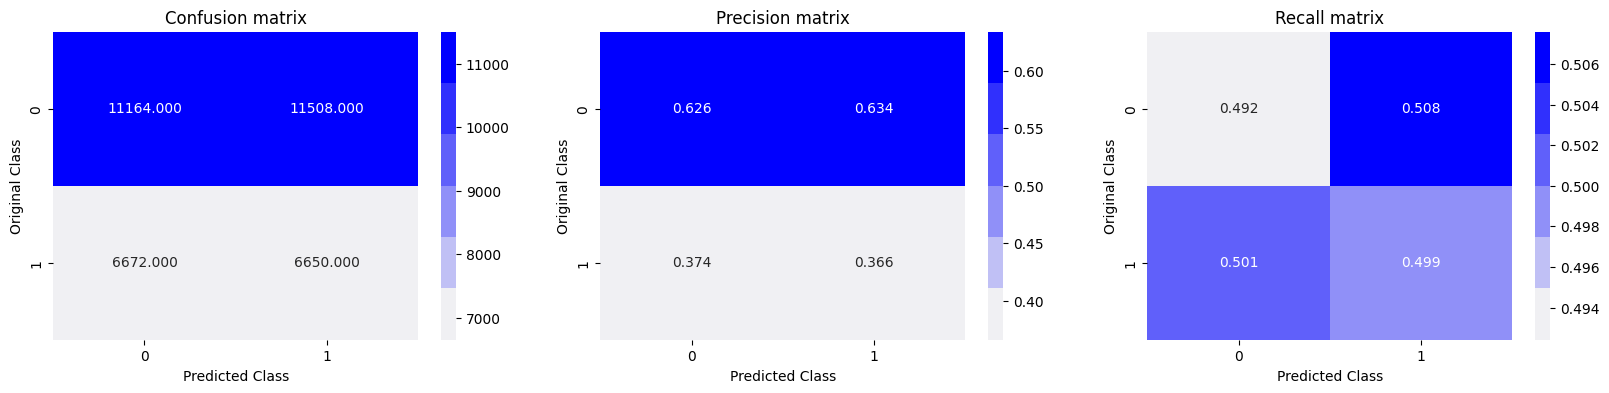

In [12]:
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y))

predicted_y =np.argmax(predicted_y, axis=1)
plot_conf_matrix(y_test, predicted_y)

<h2> Implementing Logistic Regression </h2>

For values of alpha =  1e-05 The log loss is: 0.43634255154943646
For values of alpha =  0.0001 The log loss is: 0.44239314341749375
For values of alpha =  0.001 The log loss is: 0.435816493823009
For values of alpha =  0.01 The log loss is: 0.4091918094324068
For values of alpha =  0.1 The log loss is: 0.42903950395622437
For values of alpha =  1 The log loss is: 0.4625484106387325
For values of alpha =  10 The log loss is: 0.5068484837414466


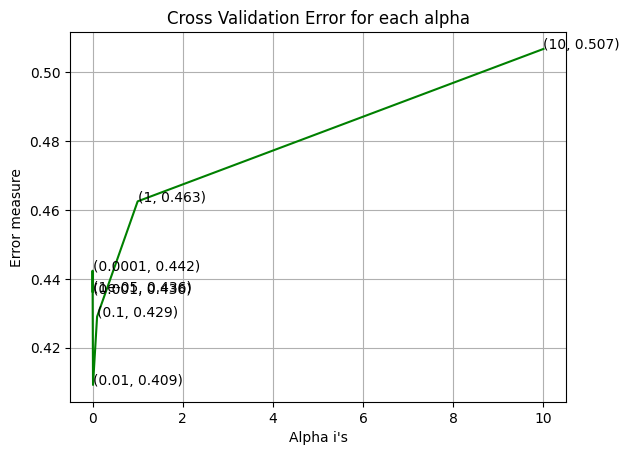

In [13]:
# Using SGD Classifier and random search CV
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array = []
for i in alpha:
    log_reg = SGDClassifier(alpha = i, loss = 'log_loss', penalty='l2', max_iter = 2000)
    log_reg.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(log_reg, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=log_reg.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=log_reg.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.40750228438026315
For values of best alpha =  0.01 The test log loss is: 0.40852927472902856
Total number of data points : 35994


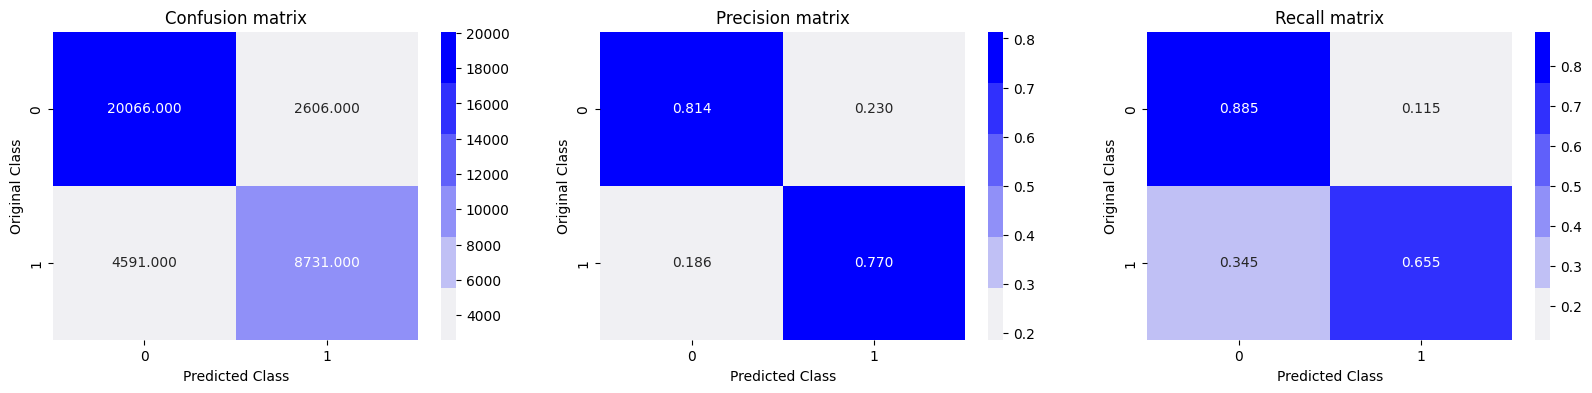

In [14]:
# Creating Function which will train the model based on best alpha
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_conf_matrix(y_test, predicted_y)

In [18]:
# Saving the model with the best param we got
# alpha = 0.01
pickle.dump(sig_clf, open('trained_model/LogisticRegression.pkl', 'wb'))

<h2> Implementing SVM Classifier</h2>

In [1]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# for storing the log errors
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

NameError: name 'SGDClassifier' is not defined

For values of best alpha =  1e-05 The train log loss is: 0.42913045250087856
For values of best alpha =  1e-05 The test log loss is: 0.4312116546335525
Total number of data points : 35994


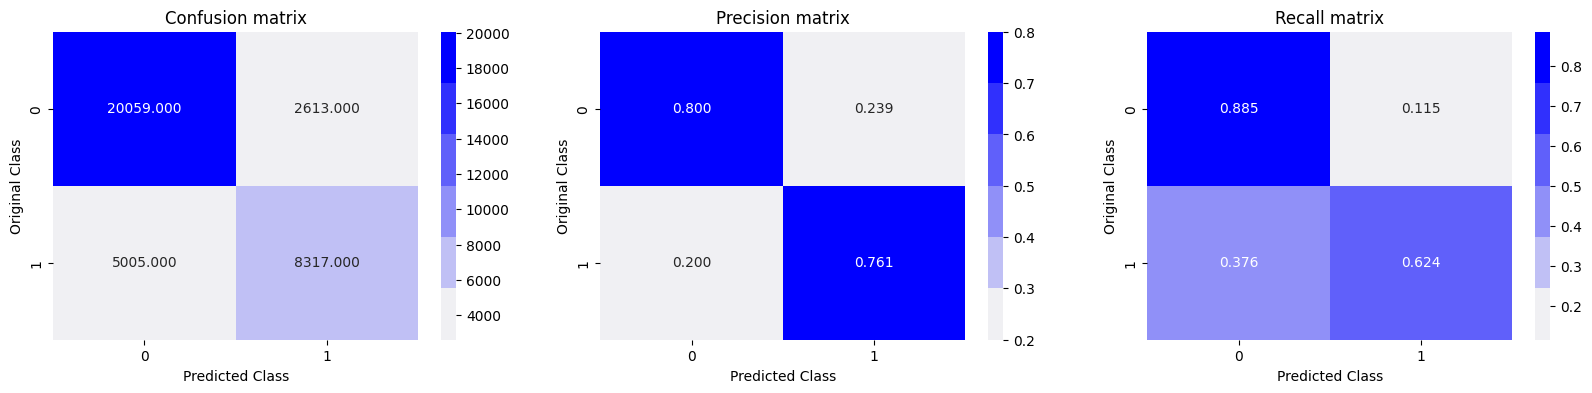

In [21]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_conf_matrix(y_test, predicted_y)

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Perform hyperparameter tuning  of XgBoost models using RandomsearchCV with vectorizer as TF-IDF W2V  to reduce the log-loss.

In [22]:
# Saving the model with the best param we got
# alpha = 0.01
pickle.dump(sig_clf, open('trained_model/SVMClassifier.pkl', 'wb'))

<h2> Implementing Decision Tree Classifier</h2>

We will not be implementing the Decision Tree on entire dataset, we will be executing it on without TF_IDF W2V filter

In [16]:
X_train_new = X_train[X_train.columns[:25]]

In [34]:
X_train_new.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

For values of max_depth =  1 The log loss is: 0.544455844958715
For values of max_depth =  2 The log loss is: 0.49799738427826257
For values of max_depth =  3 The log loss is: 0.44893484990560223
For values of max_depth =  4 The log loss is: 0.4232956779428514
For values of max_depth =  5 The log loss is: 0.40450772448019784
For values of max_depth =  6 The log loss is: 0.3891188233453702
For values of max_depth =  7 The log loss is: 0.3811993976589665
For values of max_depth =  8 The log loss is: 0.3769505664726004
For values of max_depth =  9 The log loss is: 0.3781028452538597
For values of max_depth =  10 The log loss is: 0.3779128479642476
For values of max_depth =  11 The log loss is: 0.38106078911358615
For values of max_depth =  12 The log loss is: 0.38423666954095553
For values of max_depth =  13 The log loss is: 0.3852341796705273
For values of max_depth =  14 The log loss is: 0.38812588607669674


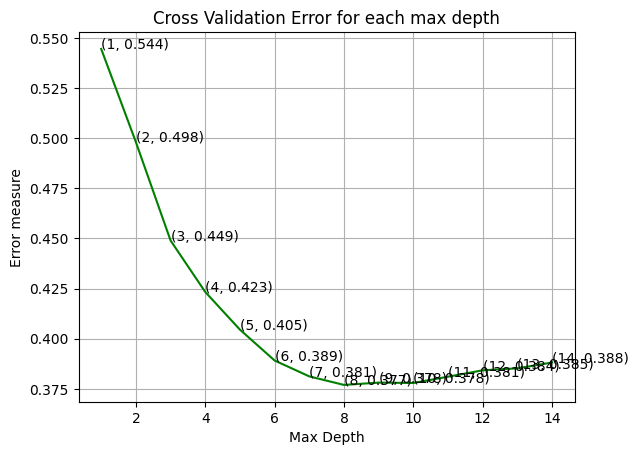

In [25]:
# Implementing Decision Tree

max_depth = range(1,15) # hyperparam for SGD classifier.

# for storing the log errors
log_error_array=[]
for i in max_depth:
    dt = DecisionTreeClassifier(max_depth=i, min_samples_leaf= 100)
    dt.fit(X_train_new, y_train)
    predict_y = dt.predict_proba(X_cv_new)
    log_error_array.append(log_loss(y_cv, predict_y, labels=dt.classes_))
    print('For values of max_depth = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=dt.classes_))

fig, ax = plt.subplots()
ax.plot(max_depth, log_error_array, c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((max_depth[i],np.round(txt,3)), (max_depth[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each max depth")
plt.xlabel("Max Depth")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  8 The train log loss is: 0.37323728170422715
For values of best alpha =  8 The test log loss is: 0.38359710536115493
Total number of data points : 35994


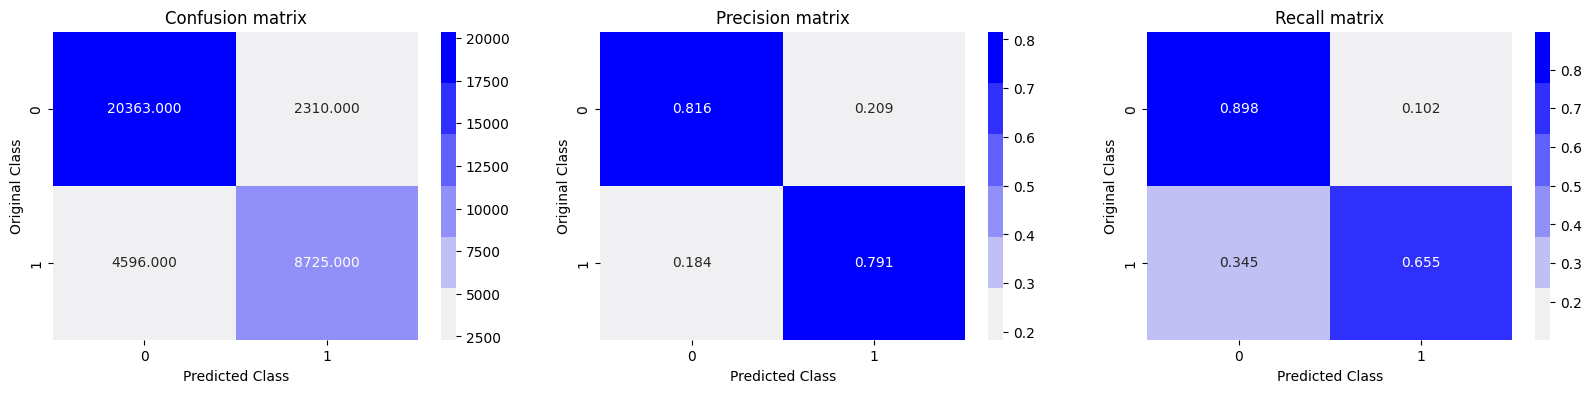

In [27]:
# Creating Function which will find best parameter and train the model based on best max depth
best_max_depth = np.argmin(log_error_array)
dt = DecisionTreeClassifier(max_depth=max_depth[best_max_depth], min_samples_leaf= 100)
dt.fit(X_train_new, y_train)
predict_y = dt.predict_proba(X_cv_new)
log_error_array.append(log_loss(y_cv, predict_y, labels=dt.classes_))

predict_y = dt.predict_proba(X_train_new)
print('For values of best alpha = ', max_depth[best_max_depth], "The train log loss is:",log_loss(y_train, predict_y, labels=dt.classes_))
predict_y = dt.predict_proba(X_test_new)
print('For values of best alpha = ', max_depth[best_max_depth], "The test log loss is:",log_loss(y_test, predict_y, labels=dt.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_conf_matrix(y_test, predicted_y)

In [28]:
# Saving the model with the best param we got
# max_depth = 8
pickle.dump(dt, open('trained_model/DT.pkl', 'wb'))